In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm
import os
from scipy import stats


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_que_svm'
data_dir_que_log = '../queue_imbalance/res_que_log'
should_savefig = False

In [3]:
results_files = os.listdir(data_dir)
df_res = pd.DataFrame()
for f in results_files:
    if 'csv' not in f:
        continue
    df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))
df_res = df_res[df_res['train_matthews'] > 0]

df_res.drop(columns=[c for c in df_res.columns if 'Unnamed' in c], inplace=True)
df_res.head(4)

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
3,0.001,NaN,0.088323,que,1.0,0.000000,rbf,0.000000,0.056676,0.200000,...,0.124849,0.355052,0.576686,0.568336,0.093402,0.000000,0.000000,0.060928,0.200000,0.500000
4,0.001,NaN,0.088323,que,10.0,0.000000,rbf,0.000000,0.056676,0.200000,...,0.126933,0.359907,0.546927,0.569174,0.093402,0.000000,0.000000,0.060928,0.200000,0.500000
9,0.010,NaN,0.393233,que,0.1,0.143858,rbf,0.150025,0.385656,0.435991,...,0.124845,0.355112,0.576158,0.568330,0.386206,0.114132,0.120805,0.365972,0.446461,0.560269
10,0.010,NaN,0.430299,que,1.0,0.138241,rbf,0.145259,0.361057,0.536037,...,0.124728,0.355087,0.575806,0.568265,0.423509,0.117322,0.124583,0.349646,0.541061,0.567854


In [4]:
df_best_rbf = df_res[df_res['kernel'] == 'rbf'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_lin = df_res[df_res['kernel'] == 'linear'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_sig = df_res[df_res['kernel'] == 'sigmoid'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)

In [5]:
df_best = df_res.sort_values(by=['matthews', 'train_matthews'], ascending=False).groupby('stock').head(1)

## Distributions

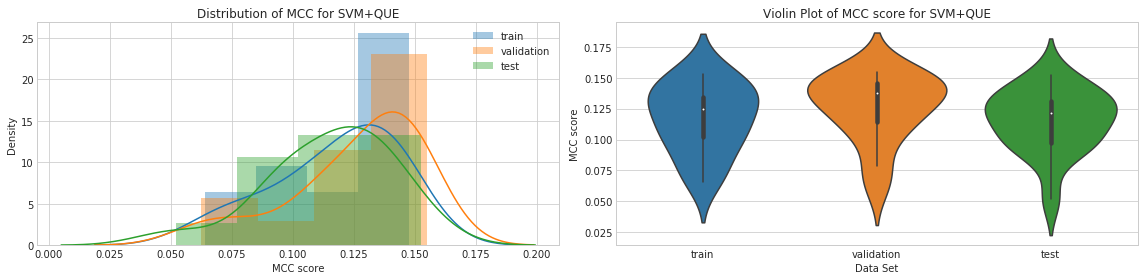

In [6]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 4))

sns.violinplot(data=df_best[['train_val_matthews', 'matthews', 'test_matthews', ]], ax=ax1)
plt.xticks([0,1,2], ['train', 'validation', 'test', ])
ax1.set_xlabel('Data Set')
ax1.set_ylabel('MCC score')
ax1.set_title('Violin Plot of MCC score for SVM+QUE')

sns.distplot(df_best[['train_matthews']], label='train', ax=ax2)
sns.distplot(df_best[['matthews']], label='validation', ax=ax2)
sns.distplot(df_best[['test_matthews']], label='test', ax=ax2)
ax2.set_title('Distribution of MCC for SVM+QUE')
ax2.set_xlabel('MCC score')
ax2.set_ylabel('Density')
ax2.legend()
plt.tight_layout()

if should_savefig:
    plt.savefig('que_svm_mcc_dist.png')

In [7]:
df_best.sort_values(by='test_matthews')[[
    'stock', 'kernel', 'test_matthews', 'matthews', 'train_matthews', 'train_val_matthews', 
    'C', 'gamma', 'coef0']]

,stock,kernel,test_matthews,matthews,train_matthews,train_val_matthews,C,gamma,coef0
141,9062,sigmoid,0.052097,0.062361,0.063964,0.065219,1.000,0.100,1.0
23,9061,rbf,0.093155,0.103318,0.085900,0.073929,1.000,0.100,NaN
27,2822,rbf,0.093790,0.114084,0.132577,0.133333,1.000,1000.000,NaN
171,9058,sigmoid,0.094555,0.078425,0.077495,0.085181,10.000,0.001,1.0
23,11583,rbf,0.099416,0.113982,0.104075,0.098840,1.000,0.100,NaN
12,9761,rbf,0.111120,0.155044,0.126633,0.130294,0.010,100.000,NaN
36,3879,rbf,0.114810,0.148129,0.141214,0.133315,100.000,0.010,NaN
218,4799,sigmoid,0.121606,0.129108,0.110880,0.109590,100.000,0.010,0.1
33,1431,sigmoid,0.124021,0.137887,0.117224,0.106834,0.001,100.000,1.0
40,10470,sigmoid,0.126214,0.142101,0.129047,0.124448,0.001,1000.000,10.0


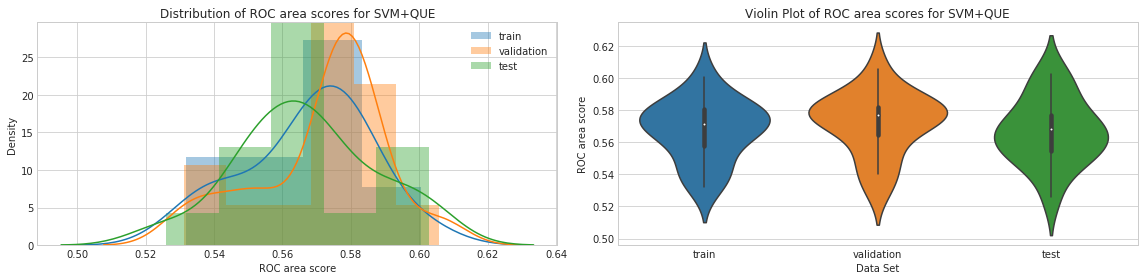

In [8]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 4))

sns.violinplot(data=df_best[['train_roc_auc', 'roc_auc', 'test_roc_auc', ]], ax=ax1)
plt.xticks([0,1,2], ['train', 'validation', 'test', ])
ax1.set_xlabel('Data Set')
ax1.set_ylabel('ROC area score')
ax1.set_title('Violin Plot of ROC area scores for SVM+QUE')

sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('Distribution of ROC area scores for SVM+QUE')
ax2.set_xlabel('ROC area score')
ax2.set_ylabel('Density')
ax2.legend()
plt.tight_layout()

if should_savefig:
    plt.savefig('que_svm_roc_auc_dist.png')

### Per kernel

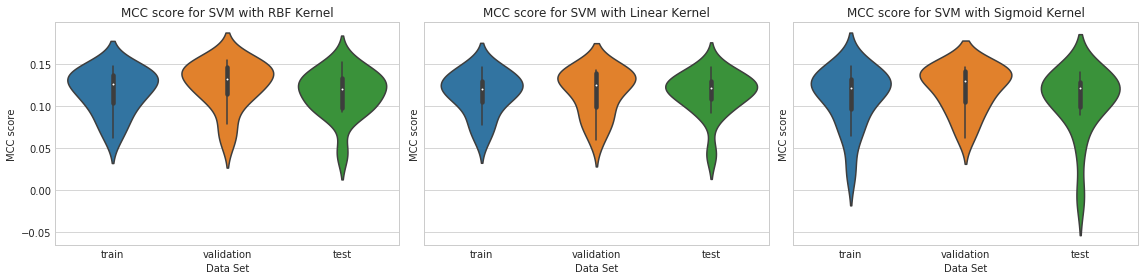

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.violinplot(data=df_best_rbf[['train_matthews', 'matthews', 'test_matthews',]], ax=ax1)
sns.violinplot(data=df_best_lin[['train_matthews', 'matthews', 'test_matthews',]], ax=ax2)
sns.violinplot(data=df_best_sig[['train_matthews', 'matthews', 'test_matthews',]], ax=ax3)
a = plt.setp([ax1, ax2, ax3], xticks=[0, 1, 2], xticklabels=['train', 'validation', 'test'], xlabel='Data Set',
            ylabel='MCC score')
ax1.set_title('MCC score for SVM with RBF Kernel')
ax2.set_title('MCC score for SVM with Linear Kernel')
ax3.set_title('MCC score for SVM with Sigmoid Kernel')
plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_mcc_per_kernel.png')

In [10]:
dd = pd.merge(df_best_rbf, df_best_lin, on='stock', suffixes=['', '_lin'])
print(dd[['train_matthews', 'matthews', 'test_matthews', 'train_matthews_lin', 'matthews_lin', 
          'test_matthews_lin']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews &   matthews &  test\_matthews &  train\_matthews\_lin &  matthews\_lin &  test\_matthews\_lin \\
\midrule
count &       15.000000 &  15.000000 &      15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &        0.117134 &   0.124851 &       0.114705 &            0.114789 &      0.116256 &           0.114962 \\
std   &        0.025720 &   0.027684 &       0.026943 &            0.024797 &      0.026978 &           0.025253 \\
min   &        0.062020 &   0.058888 &       0.043992 &            0.061270 &      0.059446 &           0.042593 \\
25\%   &        0.103975 &   0.114033 &       0.097385 &            0.104542 &      0.098334 &           0.107853 \\
50\%   &        0.126633 &   0.131952 &       0.120548 &            0.120379 &      0.124565 &           0.121280 \\
75\%   &        0.136717 &   0.145883 &       0.132796 &            0.129502 &      0.138879 &           0.129138 \\
max   &        0.14741

In [11]:
print(df_best_rbf[['train_matthews', 'matthews', 'test_matthews',]].describe().to_latex())
print(df_best_lin[['train_matthews', 'matthews', 'test_matthews',]].describe().to_latex())
print(df_best_sig[['train_matthews', 'matthews', 'test_matthews',]].describe().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  train\_matthews &   matthews &  test\_matthews \\
\midrule
count &       15.000000 &  15.000000 &      15.000000 \\
mean  &        0.117134 &   0.124851 &       0.114705 \\
std   &        0.025720 &   0.027684 &       0.026943 \\
min   &        0.062020 &   0.058888 &       0.043992 \\
25\%   &        0.103975 &   0.114033 &       0.097385 \\
50\%   &        0.126633 &   0.131952 &       0.120548 \\
75\%   &        0.136717 &   0.145883 &       0.132796 \\
max   &        0.147411 &   0.155044 &       0.152323 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &  train\_matthews &   matthews &  test\_matthews \\
\midrule
count &       15.000000 &  15.000000 &      15.000000 \\
mean  &        0.114789 &   0.116256 &       0.114962 \\
std   &        0.024797 &   0.026978 &       0.025253 \\
min   &        0.061270 &   0.059446 &       0.042593 \\
25\%   &        0.104542 &   0.098334 &       0.107853 \\
50\%   &        0.120379 &   0.12456

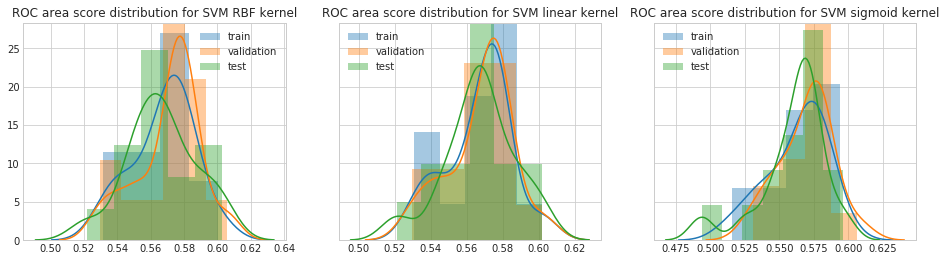

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.distplot(df_best_rbf[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best_lin[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('ROC area score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_roc_auc']], label='train', ax=ax3)
sns.distplot(df_best_sig[['roc_auc']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_roc_auc']], label='test', ax=ax3)
ax3.set_title('ROC area score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

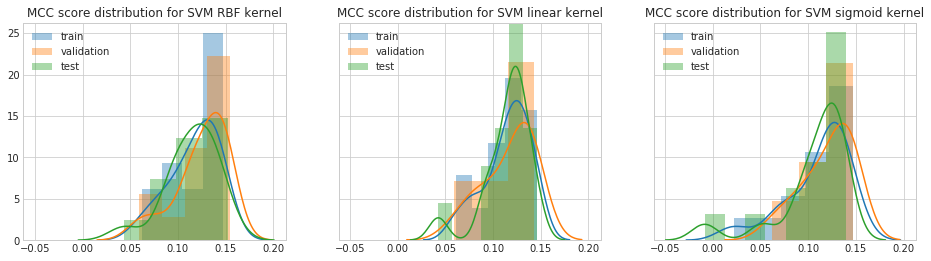

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=True)
sns.distplot(df_best_rbf[['train_matthews']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['matthews']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_matthews']], label='test', ax=ax1)
ax1.set_title('MCC score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_matthews']], label='train', ax=ax2)
sns.distplot(df_best_lin[['matthews']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_matthews']], label='test', ax=ax2)
ax2.set_title('MCC score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_matthews']], label='train', ax=ax3)
sns.distplot(df_best_sig[['matthews']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_matthews']], label='test', ax=ax3)
ax3.set_title('MCC score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

In [14]:
df_best_sig[['train_matthews', 'matthews', 'test_matthews']].describe()


,train_matthews,matthews,test_matthews
count,15.000000,15.000000,15.000000
mean,0.109992,0.120235,0.105829
std,0.034344,0.026814,0.038864
min,0.021764,0.062361,-0.008427
25%,0.096123,0.104647,0.099065
50%,0.121163,0.129108,0.121606
75%,0.132341,0.142079,0.128993
max,0.147290,0.146541,0.140110


## Compare with QUE+LOG

In [15]:
df_log = pd.DataFrame()
for f in os.listdir(data_dir_que_log):
    if 'csv' not in f:
        continue
    d = pd.read_csv(os.path.join(data_dir_que_log, f))
    df_log = df_log.append(d)

In [16]:
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])
df_best.head()

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews_log,train_precision_log,train_recall_log,train_roc_auc_log,train_val_f1_log,train_val_kappa_log,train_val_matthews_log,train_val_precision_log,train_val_recall_log,train_val_roc_auc_log
0,0.01,NaN,0.427307,que,100.00,0.146800,rbf,0.155044,0.373604,0.521666,...,0.125203,0.355774,0.572284,0.568501,0.429904,0.115188,0.124657,0.345005,0.570337,0.568988
1,0.10,NaN,0.411090,que,1000.00,0.122863,rbf,0.149000,0.299215,0.661249,...,0.132427,0.295295,0.587389,0.577876,0.397318,0.120277,0.135691,0.301660,0.582024,0.579286
2,100.00,NaN,0.453491,que,0.01,0.109754,rbf,0.148129,0.321575,0.770040,...,0.136130,0.350998,0.584954,0.575187,0.444664,0.129267,0.139997,0.357392,0.588589,0.577014
3,100.00,NaN,0.294126,que,1.00,0.111888,rbf,0.147542,0.194451,0.615188,...,0.146106,0.208106,0.611383,0.601743,0.322562,0.123626,0.156452,0.219018,0.612914,0.607457
4,1000.00,NaN,0.263692,que,0.01,0.118773,rbf,0.144224,0.251364,0.439015,...,0.105838,0.184566,0.580131,0.575084,0.263332,0.078054,0.108977,0.170085,0.593564,0.581752


In [17]:
df_best['diff_train_matthews'] = df_best['train_matthews'] - df_best['train_matthews_log'] 
df_best['diff_matthews'] = df_best['matthews'] - df_best['matthews_log'] 
df_best['diff_test_matthews'] = df_best['test_matthews'] - df_best['test_matthews_log'] 
df_best['diff_train_roc_auc'] = df_best['train_roc_auc'] - df_best['train_roc_auc_log'] 
df_best['diff_roc_auc'] = df_best['roc_auc'] - df_best['roc_auc_log'] 
df_best['diff_test_roc_auc'] = df_best['test_roc_auc'] - df_best['test_roc_auc_log'] 

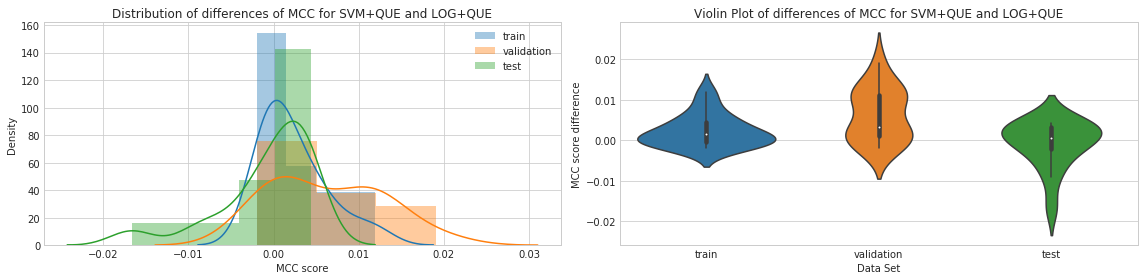

In [18]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 4))

sns.violinplot(data=df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', ]], ax=ax1)
plt.xticks([0,1,2], ['train', 'validation', 'test', ])
ax1.set_xlabel('Data Set')
ax1.set_ylabel('MCC score difference')
ax1.set_title('Violin Plot of differences of MCC for SVM+QUE and LOG+QUE')

sns.distplot(df_best[['diff_train_matthews']], label='train', ax=ax2)
sns.distplot(df_best[['diff_matthews']], label='validation', ax=ax2)
sns.distplot(df_best[['diff_test_matthews']], label='test', ax=ax2)
ax2.set_title('Distribution of differences of MCC for SVM+QUE and LOG+QUE')
ax2.set_xlabel('MCC score')
ax2.set_ylabel('Density')
ax2.legend()
plt.tight_layout()

if should_savefig:
    plt.savefig('que_svm_mcc_diff_dist.png')

In [19]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
         'diff_train_roc_auc', 'diff_roc_auc', 
         'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.002330,0.006279,-0.000841,0.000661,0.001633,-0.000898
std,0.003911,0.006471,0.005831,0.002714,0.003864,0.003940
min,-0.001963,-0.001944,-0.016644,-0.003606,-0.009033,-0.010723
25%,-0.000462,0.001011,-0.002257,-0.000549,-0.000095,-0.001577
50%,0.001430,0.003175,0.000652,0.000540,0.002156,0.000923
75%,0.004588,0.011289,0.003275,0.001105,0.004135,0.001844
max,0.011863,0.019065,0.004365,0.007352,0.007160,0.002174


In [20]:
df_best_lin = pd.merge(df_best_lin, df_log, on='stock', suffixes=['', '_log'])
df_best_lin['diff_train_matthews'] = df_best_lin['train_matthews'] - df_best_lin['train_matthews_log'] 
df_best_lin['diff_matthews'] = df_best_lin['matthews'] - df_best_lin['matthews_log'] 
df_best_lin['diff_test_matthews'] = df_best_lin['test_matthews'] - df_best_lin['test_matthews_log'] 
df_best_lin['diff_train_roc_auc'] = df_best_lin['train_roc_auc'] - df_best_lin['train_roc_auc_log'] 
df_best_lin['diff_roc_auc'] = df_best_lin['roc_auc'] - df_best_lin['roc_auc_log'] 
df_best_lin['diff_test_roc_auc'] = df_best_lin['test_roc_auc'] - df_best_lin['test_roc_auc_log'] 
df_best_rbf = pd.merge(df_best_rbf, df_log, on='stock', suffixes=['', '_log'])
df_best_rbf['diff_train_matthews'] = df_best_rbf['train_matthews'] - df_best_rbf['train_matthews_log'] 
df_best_rbf['diff_matthews'] = df_best_rbf['matthews'] - df_best_rbf['matthews_log'] 
df_best_rbf['diff_test_matthews'] = df_best_rbf['test_matthews'] - df_best_rbf['test_matthews_log'] 
df_best_rbf['diff_train_roc_auc'] = df_best_rbf['train_roc_auc'] - df_best_rbf['train_roc_auc_log'] 
df_best_rbf['diff_roc_auc'] = df_best_rbf['roc_auc'] - df_best_rbf['roc_auc_log'] 
df_best_rbf['diff_test_roc_auc'] = df_best_rbf['test_roc_auc'] - df_best_rbf['test_roc_auc_log'] 
df_best_sig = pd.merge(df_best_sig, df_log, on='stock', suffixes=['', '_log'])
df_best_sig['diff_train_matthews'] = df_best_sig['train_matthews'] - df_best_sig['train_matthews_log'] 
df_best_sig['diff_matthews'] = df_best_sig['matthews'] - df_best_sig['matthews_log'] 
df_best_sig['diff_test_matthews'] = df_best_sig['test_matthews'] - df_best_sig['test_matthews_log'] 
df_best_sig['diff_train_roc_auc'] = df_best_sig['train_roc_auc'] - df_best_sig['train_roc_auc_log'] 
df_best_sig['diff_roc_auc'] = df_best_sig['roc_auc'] - df_best_sig['roc_auc_log'] 
df_best_sig['diff_test_roc_auc'] = df_best_sig['test_roc_auc'] - df_best_sig['test_roc_auc_log'] 

In [21]:
df_best_sig[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
         'diff_train_roc_auc', 'diff_roc_auc', 
         'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,-0.004815,0.000626,-0.010149,-0.003911,-0.000857,-0.007633
std,0.022344,0.012743,0.036941,0.015625,0.011278,0.026503
min,-0.084074,-0.043148,-0.142792,-0.059576,-0.041038,-0.102710
25%,-0.000500,-0.000390,-0.004587,-0.000549,0.000232,-0.002750
50%,0.000449,0.002640,0.000563,-0.000116,0.001990,0.000397
75%,0.001987,0.006732,0.002298,0.000599,0.003691,0.001017
max,0.008256,0.009736,0.004365,0.004242,0.005749,0.002463


In [22]:
df_best_lin[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
         'diff_train_roc_auc', 'diff_roc_auc', 
         'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,-0.000018,-0.003353,-0.001017,0.000021,-0.002097,-0.000457
std,0.002041,0.013950,0.003263,0.001117,0.008270,0.001833
min,-0.002346,-0.051766,-0.006484,-0.001338,-0.030881,-0.003403
25%,-0.000982,-0.003228,-0.003295,-0.000488,-0.001900,-0.001748
50%,-0.000570,-0.000011,-0.000484,-0.000251,-0.000154,-0.000183
75%,0.000249,0.002136,0.001066,0.000183,0.001194,0.000739
max,0.005083,0.007251,0.005722,0.002885,0.003713,0.003123


In [23]:
df_best_rbf[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
         'diff_train_roc_auc', 'diff_roc_auc', 
         'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.002327,0.005242,-0.001274,0.000659,0.000880,-0.001144
std,0.003872,0.007469,0.005851,0.002698,0.004244,0.003928
min,-0.001963,-0.005097,-0.016644,-0.003606,-0.009033,-0.010723
25%,-0.000293,-0.000783,-0.003648,-0.000173,-0.001109,-0.001886
50%,0.001071,0.003026,0.000880,0.000031,-0.000109,0.000504
75%,0.004588,0.011289,0.003268,0.001103,0.004135,0.001844
max,0.011863,0.019065,0.003966,0.007352,0.007160,0.002238


In [24]:
dd = pd.merge(df_best_rbf, df_best_lin, on='stock', suffixes=['', '_lin'])

dd[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 'diff_train_matthews_lin', 
          'diff_matthews_lin', 
          'diff_test_matthews_lin',]].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_matthews_lin,diff_matthews_lin,diff_test_matthews_lin
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.002327,0.005242,-0.001274,-0.000018,-0.003353,-0.001017
std,0.003872,0.007469,0.005851,0.002041,0.013950,0.003263
min,-0.001963,-0.005097,-0.016644,-0.002346,-0.051766,-0.006484
25%,-0.000293,-0.000783,-0.003648,-0.000982,-0.003228,-0.003295
50%,0.001071,0.003026,0.000880,-0.000570,-0.000011,-0.000484
75%,0.004588,0.011289,0.003268,0.000249,0.002136,0.001066
max,0.011863,0.019065,0.003966,0.005083,0.007251,0.005722


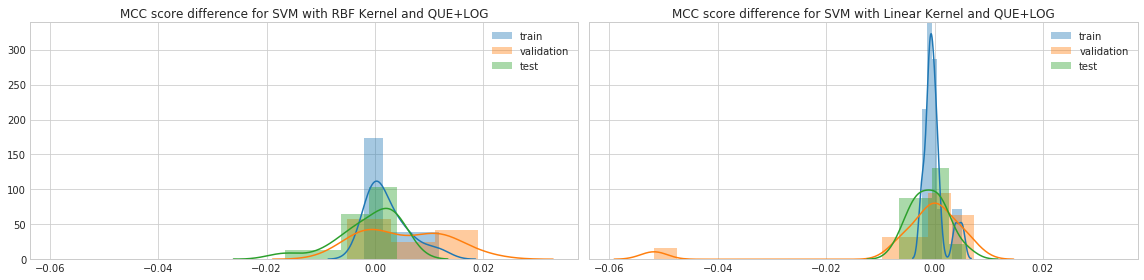

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)
sns.distplot(df_best_rbf[['diff_train_matthews']], ax=ax1, label='train')
sns.distplot(df_best_rbf[['diff_matthews']], ax=ax1, label='validation')
sns.distplot(df_best_rbf[['diff_test_matthews']], ax=ax1, label='test')
sns.distplot(df_best_lin[['diff_train_matthews']], ax=ax2, label='train')
sns.distplot(df_best_lin[['diff_matthews']], ax=ax2, label='validation')
sns.distplot(df_best_lin[['diff_test_matthews']], ax=ax2, label='test')

ax1.set_title('MCC score difference for SVM with RBF Kernel and QUE+LOG')
ax2.set_title('MCC score difference for SVM with Linear Kernel and QUE+LOG')
ax1.legend()
ax2.legend()

plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_mcc_diff_per_kernel.png')

Text(0.5,1,'MCC score difference for SVM with Sigmoid Kernel and QUE+LOG')

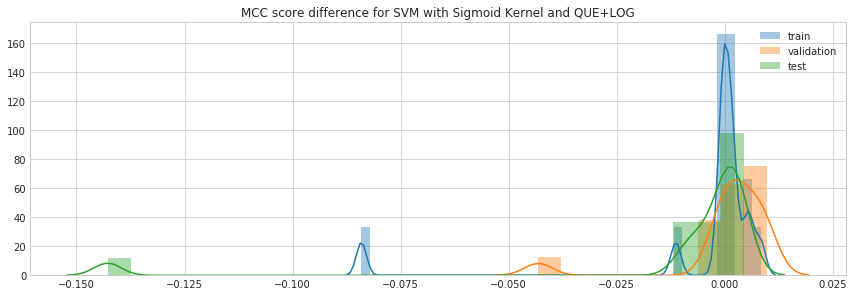

In [26]:
plt.figure(figsize=(12, 4))
sns.distplot(df_best_sig[['diff_train_matthews']], label='train')
sns.distplot(df_best_sig[['diff_matthews']], label='validation')
sns.distplot(df_best_sig[['diff_test_matthews']],  label='test')
plt.legend()
plt.tight_layout()
plt.title('MCC score difference for SVM with Sigmoid Kernel and QUE+LOG')

## McNemar's Test

In [27]:
from sklearn import utils

def get_classes_weights(y_train):
    classes = np.unique(y_train)
    class_weight_list = utils.class_weight.compute_class_weight('balanced', classes, y_train)
    class_weights = {classes[0]: class_weight_list[0], classes[1]: class_weight_list[1]}
    return class_weights

def get_svm(x_train, y_label, kernel=None, C=None, gamma=None, coef0=None):
    weights = get_classes_weights(y_label)
    clf = SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, class_weight=weights)
    clf.fit(x_train, y_label)
    return clf

def get_svm_params(df, stock):
    df_stock = df[df['stock'] == int(stock)]
    C = df_stock['C'].values[0]
    gamma = df_stock['gamma'].values[0]
    coef0 = df_stock['coef0'].values[0]
    kernel = df_stock['kernel'].values[0]
    return {
        'C': C,
        'gamma': gamma,
        'coef0': coef0,
        'kernel': kernel
    }

def get_log(x_train, y_label):
    weights = get_classes_weights(y_label)
    clf = LogisticRegression(class_weight=weights)
    clf.fit(x_train, y_label)
    return clf

In [28]:
from statsmodels.stats.contingency_tables import mcnemar
def perform_mcnemar_test(stock, df_best=None):
    data_length = 24000
    df, df_test = lob.load_prepared_data(str(stock), length=data_length)

    clf = get_svm(df[['queue_imbalance']], df['mid_price_indicator'], 
                  **get_svm_params(df_best, stock))
    clf_log = get_log(df[['queue_imbalance']], df['mid_price_indicator'])

    pred = clf.predict(df_test[['queue_imbalance']])

    pred_log = clf_log.predict(df_test[['queue_imbalance']])
    
    df_pred = pd.DataFrame()
    df_pred['svm_pred'] = pred
    df_pred['log_pred'] = pred_log
    df_pred['actual'] = df['mid_price_indicator']
    df_pred['svm_pred_correct'] = (df_pred['svm_pred'] == df_pred['actual']).astype(np.int64)
    df_pred['log_pred_correct'] = (df_pred['log_pred'] == df_pred['actual']).astype(np.int64)
    table1 = pd.crosstab(df_pred['svm_pred_correct'], df_pred['log_pred_correct'])
    res1 = mcnemar(table1, exact=False, correction=True)
    
    return res1

In [29]:
mcnemar_results = []
for stock in df_best['stock'].values:
    res1 = perform_mcnemar_test(stock, df_best=df_best)
    mcnemar_results.append({'stock': stock, 'p1': res1.pvalue, 'stat1': res1.statistic})
df_mcnemar = pd.DataFrame(mcnemar_results)
df_mcnemar.index = df_mcnemar['stock']
df_mcnemar

,p1,stat1,stock
stock,,,
9761,2.709646e-06,22.011905,9761
2730,5.469343e-04,11.948430,2730
3879,2.455095e-33,144.734216,3879
4851,1.988831e-12,49.494949,4851
2748,2.482623e-36,158.438119,2748
10470,1.590485e-15,63.516260,10470
4320,1.277224e-07,27.900415,4320
1431,4.319010e-03,8.144578,1431
4799,2.560113e-02,4.982759,4799


In [30]:
df_mcnemar[['p1']].describe()

,p1
count,1.500000e+01
mean,3.647493e-02
std,9.086853e-02
min,2.482623e-36
25%,7.097528e-12
50%,1.091358e-04
75%,1.496007e-02
max,3.346268e-01


In [31]:
df_mcnemar[df_mcnemar['p1'] > 0.1]

,p1,stat1,stock
stock,,,
9061,0.334627,0.930909,9061
9062,0.147558,2.097315,9062


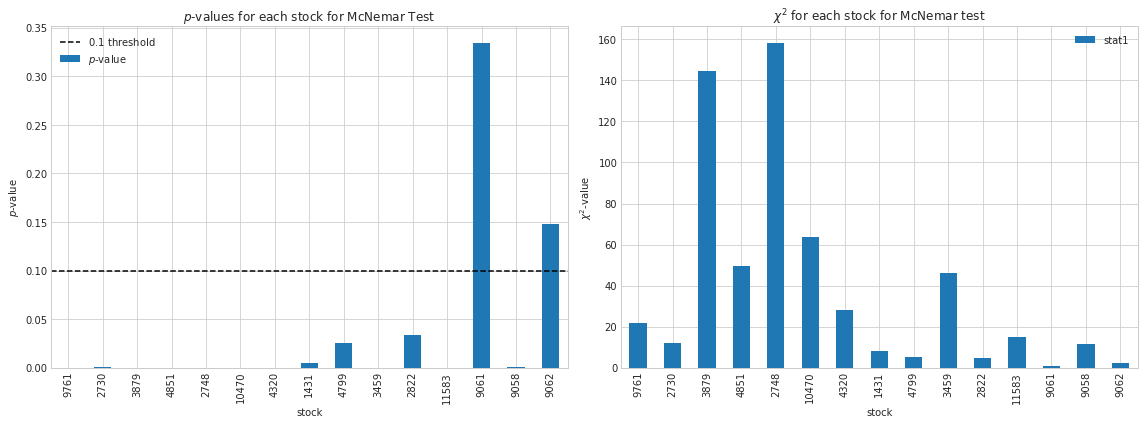

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_mcnemar[['p1']].plot(kind='bar', ax=ax1)
ax1.axhline(y=0.1, label='0.1', linestyle='--', c='black')
ax1.set_title('$p$-values for each stock')
ax1.set_ylabel('$p$-value')
ax1.legend(['$0.1$ threshold', '$p$-value'])
ax1.set_title('$p$-values for each stock for McNemar Test')

df_mcnemar[['stat1']].plot(kind='bar', ax=ax2)
ax2.set_title('$\chi^2$ for each stock')
ax2.set_ylabel('$\chi^2$-value')
ax2.set_title('$\chi^2$ for each stock for McNemar test')

plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_log_p_value.png')

#### Per kernel

In [33]:
mcnemar_results = []
for stock in df_best_lin['stock'].values:
    res1 = perform_mcnemar_test(stock, df_best=df_best_lin)
    mcnemar_results.append({'stock': stock, 'p1': res1.pvalue, 'stat1': res1.statistic})
df_mcnemar_lin = pd.DataFrame(mcnemar_results)
df_mcnemar_lin.index = df_mcnemar['stock']
df_mcnemar_lin

,p1,stat1,stock
stock,,,
9761,8.897301e-02,2.892857,9761
2730,1.362336e-03,10.256098,3879
3879,1.282952e-04,14.666667,4851
4851,1.248369e-10,41.387755,10470
2748,2.296977e-06,22.329114,2730
10470,3.218704e-05,17.284091,4320
4320,3.587954e-01,0.842105,1431
1431,2.334220e-02,5.142857,4799
4799,1.156760e-11,46.043165,3459


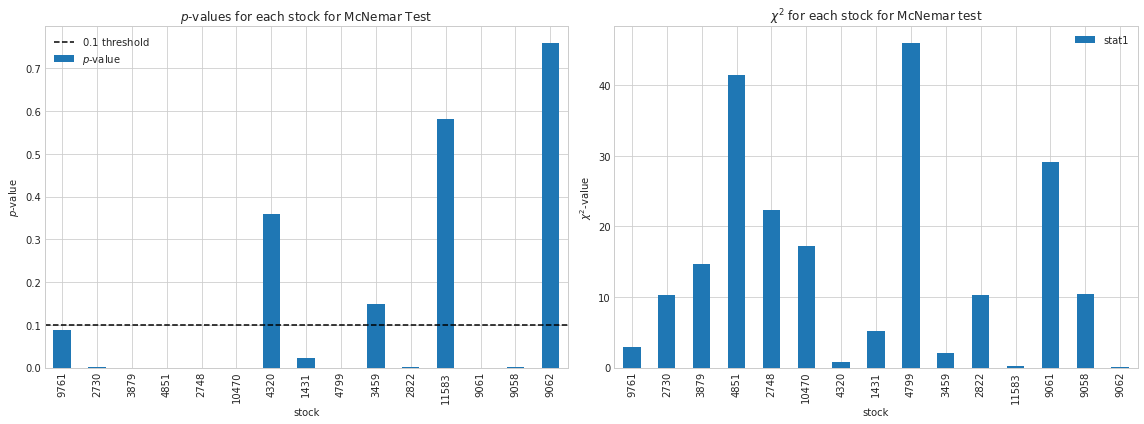

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_mcnemar_lin[['p1']].plot(kind='bar', ax=ax1)
ax1.axhline(y=0.1, label='0.1', linestyle='--', c='black')
ax1.set_title('$p$-values for each stock')
ax1.set_ylabel('$p$-value')
ax1.legend(['$0.1$ threshold', '$p$-value'])
ax1.set_title('$p$-values for each stock for McNemar Test')

df_mcnemar_lin[['stat1']].plot(kind='bar', ax=ax2)
ax2.set_title('$\chi^2$ for each stock')
ax2.set_ylabel('$\chi^2$-value')
ax2.set_title('$\chi^2$ for each stock for McNemar test')

plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_lin_log_p_value.png')

In [35]:
mcnemar_results = []
for stock in df_best_rbf['stock'].values:
    res1 = perform_mcnemar_test(stock, df_best=df_best_rbf)
    mcnemar_results.append({'stock': stock, 'p1': res1.pvalue, 'stat1': res1.statistic})
df_mcnemar_rbf = pd.DataFrame(mcnemar_results)
df_mcnemar_rbf.index = df_mcnemar['stock']
df_mcnemar_rbf

,p1,stat1,stock
stock,,,
9761,2.709646e-06,22.011905,9761
2730,5.469343e-04,11.948430,2730
3879,2.455095e-33,144.734216,3879
4851,1.988831e-12,49.494949,4851
2748,2.482623e-36,158.438119,2748
10470,2.403701e-07,26.677778,10470
4320,1.277224e-07,27.900415,4320
1431,5.402914e-01,0.375000,1431
4799,4.550026e-02,4.000000,4799


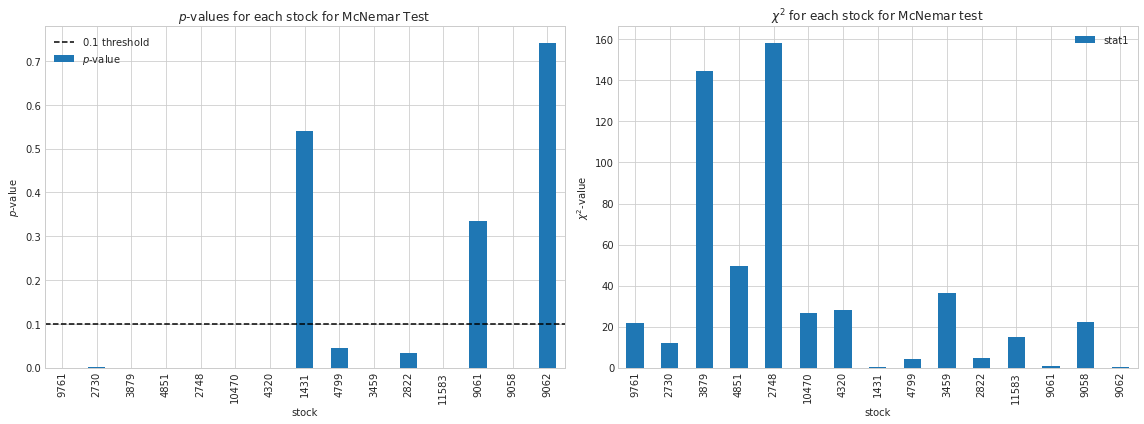

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_mcnemar_rbf[['p1']].plot(kind='bar', ax=ax1)
ax1.axhline(y=0.1, label='0.1', linestyle='--', c='black')
ax1.set_title('$p$-values for each stock')
ax1.set_ylabel('$p$-value')
ax1.legend(['$0.1$ threshold', '$p$-value'])
ax1.set_title('$p$-values for each stock for McNemar Test')

df_mcnemar_rbf[['stat1']].plot(kind='bar', ax=ax2)
ax2.set_title('$\chi^2$ for each stock')
ax2.set_ylabel('$\chi^2$-value')
ax2.set_title('$\chi^2$ for each stock for McNemar test')

plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_rbf_log_p_value.png')

In [37]:
mcnemar_results = []
for stock in df_best_sig['stock'].values:
    res1 = perform_mcnemar_test(stock, df_best=df_best_sig)
    mcnemar_results.append({'stock': stock, 'p1': res1.pvalue, 'stat1': res1.statistic})
df_mcnemar_sig = pd.DataFrame(mcnemar_results)
df_mcnemar_sig.index = df_mcnemar['stock']


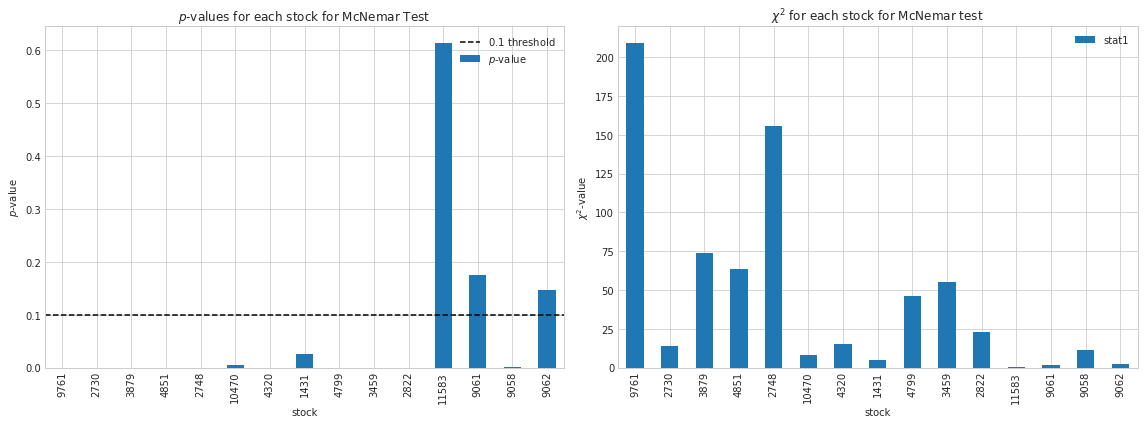

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_mcnemar_sig[['p1']].plot(kind='bar', ax=ax1)
ax1.axhline(y=0.1, label='0.1', linestyle='--', c='black')
ax1.set_title('$p$-values for each stock')
ax1.set_ylabel('$p$-value')
ax1.legend(['$0.1$ threshold', '$p$-value'])
ax1.set_title('$p$-values for each stock for McNemar Test')

df_mcnemar_sig[['stat1']].plot(kind='bar', ax=ax2)
ax2.set_title('$\chi^2$ for each stock')
ax2.set_ylabel('$\chi^2$-value')
ax2.set_title('$\chi^2$ for each stock for McNemar test')

plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_sig_log_p_value.png')

In [39]:
df_p = pd.merge(df_mcnemar_lin, df_mcnemar_rbf, on='stock', suffixes=['_lin', '_rbf'])
df_p = pd.merge(df_p, df_mcnemar_sig, on='stock', suffixes=['', '_sig'])
df_p.index = df_p['stock']

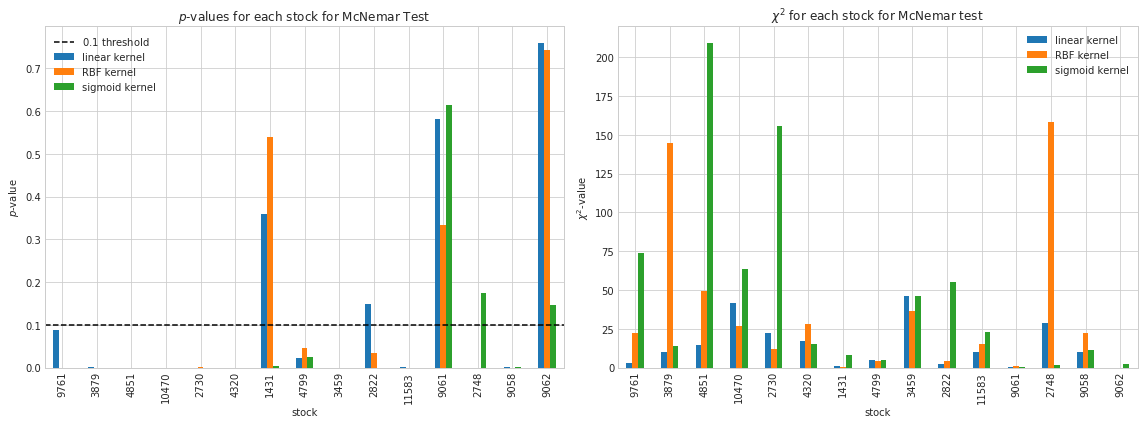

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_p[['p1_lin', 'p1_rbf', 'p1']].plot(kind='bar', ax=ax1)
ax1.axhline(y=0.1, label='0.1', linestyle='--', c='black')
ax1.set_title('$p$-values for each stock')
ax1.set_ylabel('$p$-value')
ax1.legend(['$0.1$ threshold', 'linear kernel', 'RBF kernel', 'sigmoid kernel'])
ax1.set_title('$p$-values for each stock for McNemar Test')

df_p[['stat1_lin', 'stat1_rbf', 'stat1']].plot(kind='bar', ax=ax2)
ax2.set_title('$\chi^2$ for each stock')
ax2.set_ylabel('$\chi^2$-value')
ax2.legend(['linear kernel', 'RBF kernel', 'sigmoid kernel'])
ax2.set_title('$\chi^2$ for each stock for McNemar test')

plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_log_mcnemar_per_kernel.png')

In [41]:
df_p[['p1_lin', 'p1_rbf', 'p1']].sort_values(by='p1', ascending=False)

,p1_lin,p1_rbf,p1
stock,,,
9061,5.827020e-01,3.346268e-01,6.142947e-01
2748,6.906029e-08,2.482623e-36,1.757812e-01
9062,7.603683e-01,7.423084e-01,1.475580e-01
4799,2.334220e-02,4.550026e-02,2.560113e-02
1431,3.587954e-01,5.402914e-01,4.319010e-03
9058,1.248831e-03,2.285337e-06,7.120116e-04
3879,1.362336e-03,2.455095e-33,2.173038e-04
4320,3.218704e-05,1.277224e-07,1.071079e-04
11583,1.362336e-03,1.091358e-04,1.646233e-06


### Regular comparision of scores

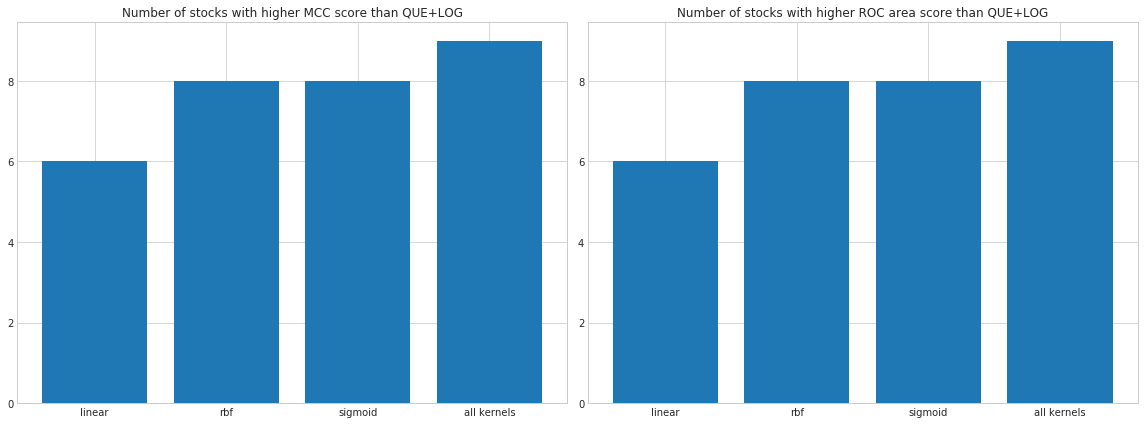

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lin = len(df_best_lin[df_best_lin['test_matthews'] > df_best_lin['test_matthews_log']])
rbf = len(df_best_rbf[df_best_rbf['test_matthews'] > df_best_rbf['test_matthews_log']])
sig = len(df_best_sig[df_best_sig['test_matthews'] > df_best_sig['test_matthews_log']])
b = len(df_best[df_best['test_matthews'] > df_best['test_matthews_log']])
ax1.bar(['linear', 'rbf', 'sigmoid', 'all kernels'], [lin, rbf, sig, b])
ax1.set_title('Number of stocks with higher MCC score than QUE+LOG')

lin = len(df_best_lin[df_best_lin['test_roc_auc'] > df_best_lin['test_roc_auc_log']])
rbf = len(df_best_rbf[df_best_rbf['test_roc_auc'] > df_best_rbf['test_roc_auc_log']])
sig = len(df_best_sig[df_best_sig['test_roc_auc'] > df_best_sig['test_roc_auc_log']])
b = len(df_best[df_best['test_roc_auc'] > df_best['test_roc_auc_log']])
ax2.bar(['linear', 'rbf', 'sigmoid', 'all kernels'], [lin, rbf, sig, b])
ax2.set_title('Number of stocks with higher ROC area score than QUE+LOG')
plt.tight_layout()
if should_savefig:
    plt.savefig('que_svm_vs_log_bar.png')